In [58]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim

from tqdm import tqdm
import random 
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image 


In [59]:
plt.style.use('ggplot')
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [60]:
# setting the seed
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [61]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [62]:
model = models.resnet18(pretrained=True)

output = model(torch.randn(32, 3, 224, 224))

output.shape

c:\Users\Meiras\anaconda3\envs\deeplearning\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Meiras\anaconda3\envs\deeplearning\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([32, 1000])

In [63]:
# loading the weights of ResNet18
model = models.resnet18(pretrained=True)

# changing the last layer of resnet18 
num_classes = 3
model.fc = nn.Linear(model.fc.in_features, num_classes)

In [64]:
model(torch.randn(1, 3, 224, 224))
# model(torch.randn(1, 3, 224, 224)).shape

tensor([[-0.6716, -0.6018,  0.4231]], grad_fn=<AddmmBackward0>)

In [65]:
# defining the path for our dataset
train_folder = 'dataset/train'
val_folder = 'dataset/validation'

# basic/no transformations 
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# creating datasets
train_dataset = ImageFolder(train_folder, transform=train_transform)
val_dataset = ImageFolder(val_folder, transform=val_transforms)

In [66]:
train_dataset[400][0].shape

torch.Size([3, 224, 224])

In [67]:
val_dataset

Dataset ImageFolder
    Number of datapoints: 114
    Root location: dataset/validation
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [68]:
# List of predicting classes 
class_list = train_dataset.classes
class_list 

['adidas', 'converse', 'nike']

In [69]:
# creating dataloaders
batch_size = 64
train_loader = DataLoader(dataset=train_dataset,
                        batch_size=batch_size,
                        shuffle=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=batch_size,
                        shuffle=False)

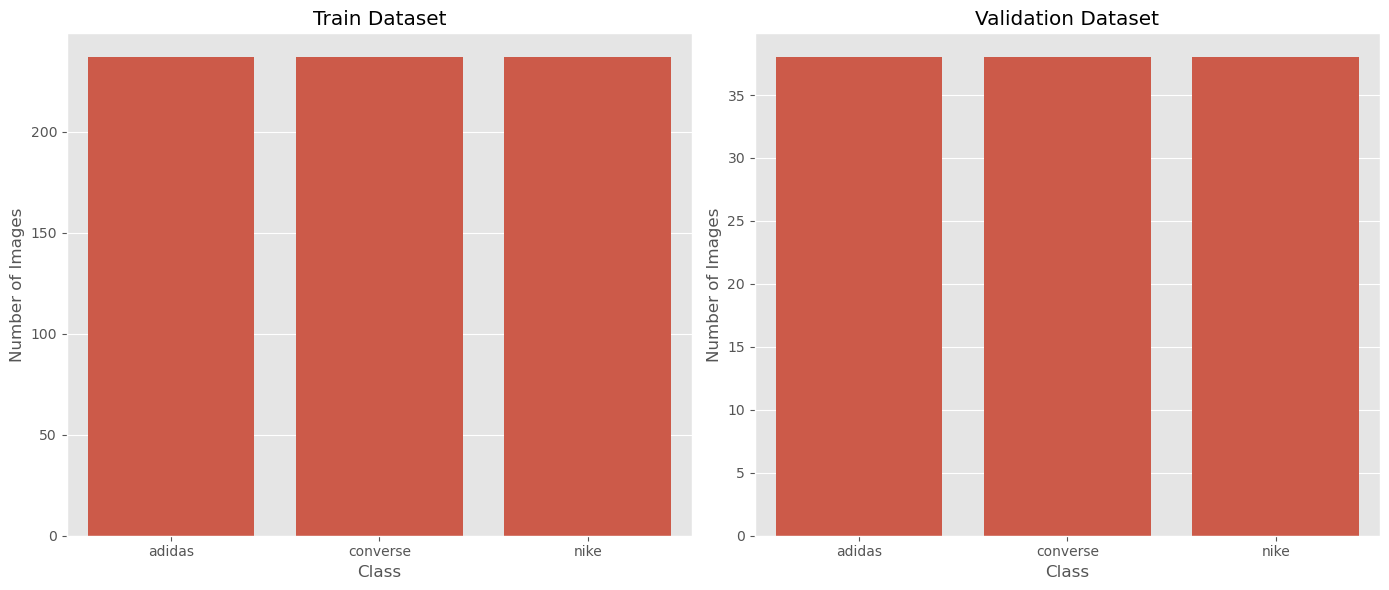

In [70]:
# Distribution of the each classes and how many images are in each classses
train_class_count = np.zeros(len(class_list))
for _, label in train_dataset:
    train_class_count[label] += 1
    
val_class_count = np.zeros(len(class_list))
for _, label in val_dataset:
    val_class_count[label] += 1

# draw the barplot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Barplot for train data
sns.barplot(x=class_list, y=train_class_count, ax=ax[0])
ax[0].set_title('Train Dataset')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Number of Images')
ax[0].tick_params(axis='x')

# Barplot for val data
sns.barplot(x=class_list, y=val_class_count, ax=ax[1])
ax[1].set_title('Validation Dataset')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Number of Images')
ax[1].tick_params(axis='x')

plt.tight_layout()
plt.show()

Images without normalization: 


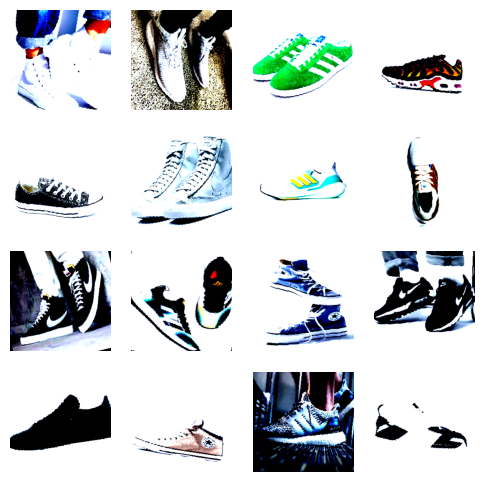

In [81]:
# function to visualize the images in our batch
def show_images(images, denormalize=False):
    if denormalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([[0.229, 0.224, 0.225]])
        images = images.numpy().transpose((0, 2, 3, 1))
        images = std * images + mean
        images = np.clip(images, 0, 1)
    
    else:
        images = images.numpy().transpose((0, 2, 3, 1))
    
    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.axis('off')
    plt.show()
    
# getting the first batch    
images, _ = next(iter(train_loader))

# visualizing the images in their original form
print('Images without normalization: ')
show_images(images, denormalize=False)

In [71]:
# How many batches in one epoch?
len(train_loader), len(val_loader)

(12, 2)

In [72]:
# Validation model before training:
model.eval()
model.to(device)
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        print(outputs.shape)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
val_accuracy = correct / total
print(val_accuracy)

 50%|█████     | 1/2 [00:00<00:00,  1.51it/s]

torch.Size([64, 3])
torch.Size([50, 3])


100%|██████████| 2/2 [00:01<00:00,  1.91it/s]

0.34210526315789475


In [73]:
# Training our model:
num_epochs = 25
learning_rate = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_accuracy = 0
model.to(device)

for epoch in range(num_epochs):
    # Train mode:
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation mode:
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
    val_loss /= len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch[{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    
    # save the best model based on val accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print('Saved best model')
        
    # save the last model
    torch.save(model.state_dict(), 'last_model.pth')
    print()
    
print('Training and validation is complete')

100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


Epoch[1/25], Train Loss: 0.8793, Train Accuracy: 0.6048, Validation Loss: 0.7511, Validation Accuracy: 0.7368
Saved best model



100%|██████████| 2/2 [00:00<00:00,  2.44it/s]


Epoch[2/25], Train Loss: 0.2139, Train Accuracy: 0.9620, Validation Loss: 0.4808, Validation Accuracy: 0.8509
Saved best model



100%|██████████| 2/2 [00:00<00:00,  2.47it/s]


Epoch[3/25], Train Loss: 0.0698, Train Accuracy: 0.9958, Validation Loss: 0.3808, Validation Accuracy: 0.8596
Saved best model



100%|██████████| 2/2 [00:00<00:00,  2.46it/s]


Epoch[4/25], Train Loss: 0.0254, Train Accuracy: 1.0000, Validation Loss: 0.3983, Validation Accuracy: 0.8684
Saved best model



100%|██████████| 2/2 [00:00<00:00,  2.44it/s]


Epoch[5/25], Train Loss: 0.0378, Train Accuracy: 0.9986, Validation Loss: 0.4169, Validation Accuracy: 0.8246



100%|██████████| 2/2 [00:00<00:00,  2.44it/s]


Epoch[6/25], Train Loss: 0.0233, Train Accuracy: 1.0000, Validation Loss: 0.4914, Validation Accuracy: 0.8421



100%|██████████| 2/2 [00:00<00:00,  2.46it/s]


Epoch[7/25], Train Loss: 0.0394, Train Accuracy: 0.9986, Validation Loss: 0.5398, Validation Accuracy: 0.8070



100%|██████████| 2/2 [00:00<00:00,  2.41it/s]


Epoch[8/25], Train Loss: 0.0314, Train Accuracy: 0.9944, Validation Loss: 0.5942, Validation Accuracy: 0.7982



100%|██████████| 2/2 [00:00<00:00,  2.46it/s]


Epoch[9/25], Train Loss: 0.0150, Train Accuracy: 0.9986, Validation Loss: 0.5078, Validation Accuracy: 0.8158



100%|██████████| 2/2 [00:00<00:00,  2.42it/s]


Epoch[10/25], Train Loss: 0.0166, Train Accuracy: 1.0000, Validation Loss: 0.3757, Validation Accuracy: 0.8421



100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


Epoch[11/25], Train Loss: 0.0143, Train Accuracy: 0.9986, Validation Loss: 0.4104, Validation Accuracy: 0.8421



100%|██████████| 2/2 [00:00<00:00,  2.44it/s]


Epoch[12/25], Train Loss: 0.0110, Train Accuracy: 0.9986, Validation Loss: 0.4085, Validation Accuracy: 0.8333



100%|██████████| 2/2 [00:00<00:00,  2.41it/s]


Epoch[13/25], Train Loss: 0.0046, Train Accuracy: 1.0000, Validation Loss: 0.4306, Validation Accuracy: 0.8158



100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


Epoch[14/25], Train Loss: 0.0039, Train Accuracy: 1.0000, Validation Loss: 0.4341, Validation Accuracy: 0.8421



100%|██████████| 2/2 [00:00<00:00,  2.40it/s]


Epoch[15/25], Train Loss: 0.0100, Train Accuracy: 1.0000, Validation Loss: 0.4260, Validation Accuracy: 0.8596



100%|██████████| 2/2 [00:00<00:00,  2.42it/s]


Epoch[16/25], Train Loss: 0.0324, Train Accuracy: 0.9958, Validation Loss: 0.4262, Validation Accuracy: 0.8509



100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


Epoch[17/25], Train Loss: 0.0221, Train Accuracy: 0.9930, Validation Loss: 0.4406, Validation Accuracy: 0.8333



100%|██████████| 2/2 [00:00<00:00,  2.42it/s]


Epoch[18/25], Train Loss: 0.0168, Train Accuracy: 0.9986, Validation Loss: 0.4497, Validation Accuracy: 0.8333



100%|██████████| 2/2 [00:00<00:00,  2.25it/s]


Epoch[19/25], Train Loss: 0.0151, Train Accuracy: 0.9958, Validation Loss: 0.4126, Validation Accuracy: 0.8509



100%|██████████| 2/2 [00:00<00:00,  2.40it/s]


Epoch[20/25], Train Loss: 0.0095, Train Accuracy: 0.9986, Validation Loss: 0.3726, Validation Accuracy: 0.8509



100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


Epoch[21/25], Train Loss: 0.0096, Train Accuracy: 1.0000, Validation Loss: 0.3225, Validation Accuracy: 0.8509



100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


Epoch[22/25], Train Loss: 0.0074, Train Accuracy: 1.0000, Validation Loss: 0.3687, Validation Accuracy: 0.8684



100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


Epoch[23/25], Train Loss: 0.0103, Train Accuracy: 0.9986, Validation Loss: 0.4810, Validation Accuracy: 0.8596



100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


Epoch[24/25], Train Loss: 0.0958, Train Accuracy: 0.9972, Validation Loss: 0.4126, Validation Accuracy: 0.8772
Saved best model



100%|██████████| 2/2 [00:00<00:00,  2.31it/s]

Epoch[25/25], Train Loss: 0.0942, Train Accuracy: 0.9775, Validation Loss: 0.4754, Validation Accuracy: 0.8509

Training and validation is complete


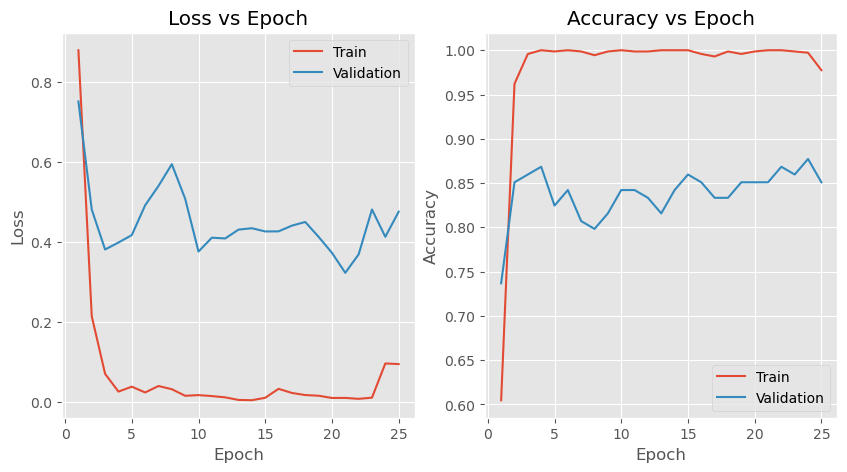

In [74]:
# Plot the graphs
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()

plt.show()

In [75]:
# evaluate
def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    accuracy = np.sum(np.diag(cm) / np.sum(cm))
    # F1 score
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')
    return cm, report, accuracy, weighted_f1

def plot_confusion_matrix(cm, classes):
    with plt.style.context('default'):
        plt.figure(figsize=(5, 4))
        sns.set(font_scale=1.0)
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False,
                    xticklabels=classes, yticklabels=classes)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion matrix')
        plt.show()

Metrics for current model: 
              precision    recall  f1-score   support

           0       0.89      0.87      0.88        38
           1       0.83      0.92      0.88        38
           2       0.91      0.84      0.88        38

    accuracy                           0.88       114
   macro avg       0.88      0.88      0.88       114
weighted avg       0.88      0.88      0.88       114

Test Accuracy: 0.8772


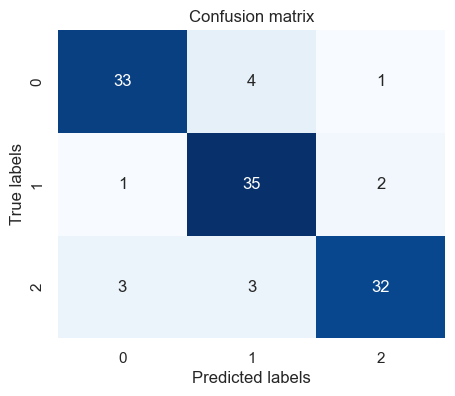

In [76]:
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)

cm, report, accuracy_1, weighted_f1_1 = evaluate_model(model, val_loader)
print('Metrics for current model: ')
print(report)
print(f'Test Accuracy: {accuracy_1:.4f}')
plot_confusion_matrix(cm, classes=list(range(3)))

In [77]:
# Adding augmentations to prevent overfitting problem and better generalize on the validation dataset
# loading the weights of ResNet18
model = models.resnet18(pretrained=True)

# changing the last layer of resnet18 
num_classes = 3
model.fc = nn.Linear(model.fc.in_features, num_classes)

c:\Users\Meiras\anaconda3\envs\deeplearning\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Meiras\anaconda3\envs\deeplearning\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [79]:
# defining the path for our dataset
train_folder = 'dataset/train'
val_folder = 'dataset/validation'

# basic/no transformations 
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomRotation(15),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(0.4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# creating datasets
train_dataset = ImageFolder(train_folder, transform=train_transform)
val_dataset = ImageFolder(val_folder, transform=val_transforms)

# dataloader
batch_size=64
train_loader = DataLoader(dataset=train_dataset,
                        batch_size=batch_size,
                        shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=batch_size,
                        shuffle=False)

Images without Normalization


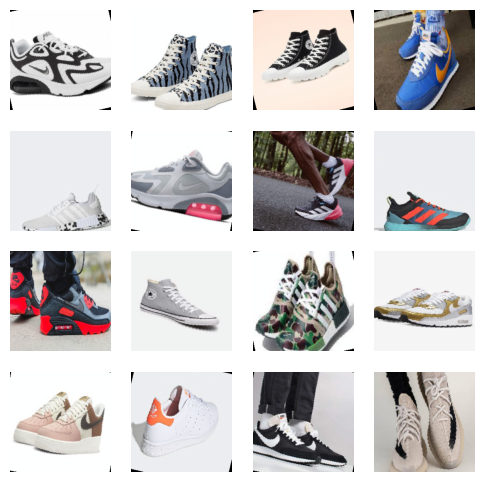

In [82]:
images, _ = next(iter(train_loader))

print('Images without Normalization')
show_images(images, denormalize=True)

In [83]:
# Training our model:
num_epochs = 25
learning_rate = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_accuracy = 0
model.to(device)

for epoch in range(num_epochs):
    # Train mode:
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation mode:
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
    val_loss /= len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch[{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    
    # save the best model based on val accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print('Saved best model')
        
    # save the last model
    torch.save(model.state_dict(), 'last_model.pth')
    print()
    
print('Training and validation is complete')

100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


Epoch[1/25], Train Loss: 0.8420, Train Accuracy: 0.5935, Validation Loss: 0.6313, Validation Accuracy: 0.7719
Saved best model



100%|██████████| 2/2 [00:00<00:00,  2.28it/s]


Epoch[2/25], Train Loss: 0.3336, Train Accuracy: 0.9030, Validation Loss: 0.4373, Validation Accuracy: 0.8509
Saved best model



100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


Epoch[3/25], Train Loss: 0.1912, Train Accuracy: 0.9451, Validation Loss: 0.3996, Validation Accuracy: 0.8684
Saved best model



100%|██████████| 2/2 [00:00<00:00,  2.23it/s]


Epoch[4/25], Train Loss: 0.1121, Train Accuracy: 0.9691, Validation Loss: 0.3308, Validation Accuracy: 0.8947
Saved best model



100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


Epoch[5/25], Train Loss: 0.0903, Train Accuracy: 0.9803, Validation Loss: 0.3445, Validation Accuracy: 0.8860



100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


Epoch[6/25], Train Loss: 0.0458, Train Accuracy: 0.9930, Validation Loss: 0.3683, Validation Accuracy: 0.8333



100%|██████████| 2/2 [00:00<00:00,  2.24it/s]


Epoch[7/25], Train Loss: 0.0325, Train Accuracy: 0.9944, Validation Loss: 0.3115, Validation Accuracy: 0.8509



100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


Epoch[8/25], Train Loss: 0.0383, Train Accuracy: 0.9958, Validation Loss: 0.2855, Validation Accuracy: 0.8860



100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


Epoch[9/25], Train Loss: 0.0418, Train Accuracy: 0.9902, Validation Loss: 0.2737, Validation Accuracy: 0.8684



100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


Epoch[10/25], Train Loss: 0.0490, Train Accuracy: 0.9930, Validation Loss: 0.2728, Validation Accuracy: 0.8947



100%|██████████| 2/2 [00:00<00:00,  2.37it/s]


Epoch[11/25], Train Loss: 0.0622, Train Accuracy: 0.9817, Validation Loss: 0.4191, Validation Accuracy: 0.8596



100%|██████████| 2/2 [00:00<00:00,  2.37it/s]


Epoch[12/25], Train Loss: 0.0292, Train Accuracy: 0.9972, Validation Loss: 0.3916, Validation Accuracy: 0.8772



100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


Epoch[13/25], Train Loss: 0.0219, Train Accuracy: 0.9972, Validation Loss: 0.3636, Validation Accuracy: 0.8684



100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


Epoch[14/25], Train Loss: 0.0244, Train Accuracy: 0.9972, Validation Loss: 0.3092, Validation Accuracy: 0.9035
Saved best model



100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


Epoch[15/25], Train Loss: 0.0214, Train Accuracy: 0.9958, Validation Loss: 0.2889, Validation Accuracy: 0.9123
Saved best model



100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


Epoch[16/25], Train Loss: 0.0311, Train Accuracy: 0.9958, Validation Loss: 0.3001, Validation Accuracy: 0.9035



100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


Epoch[17/25], Train Loss: 0.0119, Train Accuracy: 1.0000, Validation Loss: 0.3764, Validation Accuracy: 0.8947



100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


Epoch[18/25], Train Loss: 0.0329, Train Accuracy: 0.9972, Validation Loss: 0.3274, Validation Accuracy: 0.9211
Saved best model



100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


Epoch[19/25], Train Loss: 0.0121, Train Accuracy: 0.9986, Validation Loss: 0.2985, Validation Accuracy: 0.8947



100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


Epoch[20/25], Train Loss: 0.0166, Train Accuracy: 0.9986, Validation Loss: 0.3063, Validation Accuracy: 0.9123



100%|██████████| 2/2 [00:00<00:00,  2.25it/s]


Epoch[21/25], Train Loss: 0.0103, Train Accuracy: 1.0000, Validation Loss: 0.3102, Validation Accuracy: 0.9035



100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


Epoch[22/25], Train Loss: 0.0086, Train Accuracy: 1.0000, Validation Loss: 0.3074, Validation Accuracy: 0.9035



100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


Epoch[23/25], Train Loss: 0.0436, Train Accuracy: 0.9986, Validation Loss: 0.3041, Validation Accuracy: 0.9211



100%|██████████| 2/2 [00:00<00:00,  2.25it/s]


Epoch[24/25], Train Loss: 0.0372, Train Accuracy: 0.9887, Validation Loss: 0.2820, Validation Accuracy: 0.8947



100%|██████████| 2/2 [00:01<00:00,  1.95it/s]

Epoch[25/25], Train Loss: 0.0408, Train Accuracy: 0.9916, Validation Loss: 0.2907, Validation Accuracy: 0.9123

Training and validation is complete


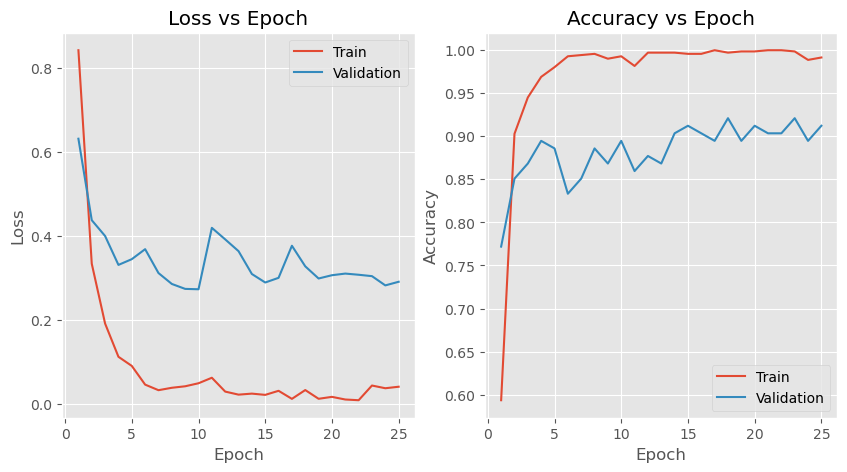

In [84]:
# Plot the graphs
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()

plt.show()

In [85]:
# evaluate
def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    accuracy = np.sum(np.diag(cm) / np.sum(cm))
    # F1 score
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')
    return cm, report, accuracy, weighted_f1

def plot_confusion_matrix(cm, classes):
    with plt.style.context('default'):
        plt.figure(figsize=(5, 4))
        sns.set(font_scale=1.0)
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False,
                    xticklabels=classes, yticklabels=classes)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion matrix')
        plt.show()

Metrics for current model: 
              precision    recall  f1-score   support

           0       0.90      0.95      0.92        38
           1       0.92      0.95      0.94        38
           2       0.94      0.87      0.90        38

    accuracy                           0.92       114
   macro avg       0.92      0.92      0.92       114
weighted avg       0.92      0.92      0.92       114

Test Accuracy: 0.9211


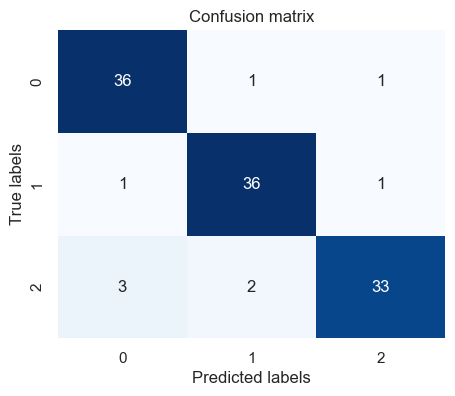

In [86]:
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)

cm, report, accuracy_1, weighted_f1_1 = evaluate_model(model, val_loader)
print('Metrics for current model: ')
print(report)
print(f'Test Accuracy: {accuracy_1:.4f}')
plot_confusion_matrix(cm, classes=list(range(3)))

tensor([[ 5.7029, -1.4133, -4.1459]], device='cuda:0')
tensor([9.9914e-01, 8.1109e-04, 5.2762e-05])


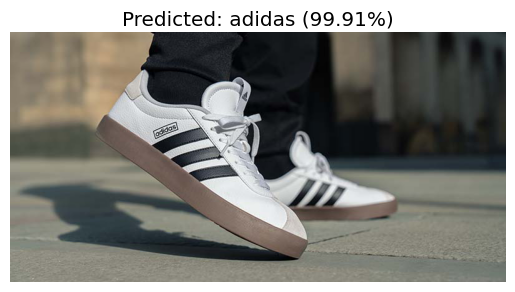

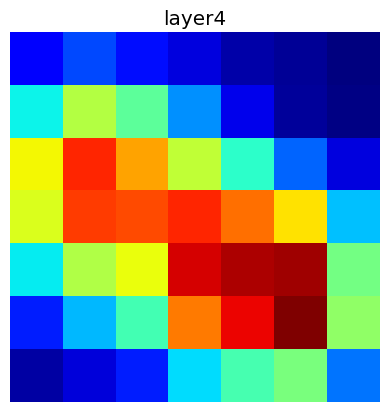

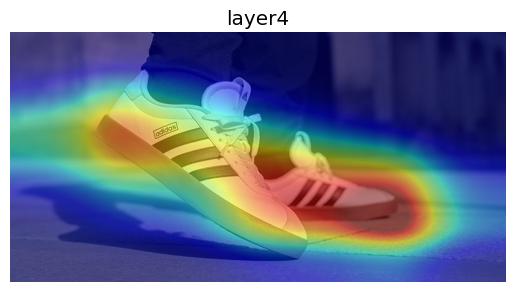

In [114]:
# Visualizing which parts of the image affect the CNN 

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models, transforms
from torchcam.methods import CAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image

model = models.resnet18()

num_classes = 3
model.fc = nn.Linear(model.fc.in_features, num_classes)

model.load_state_dict(torch.load('best_model.pth'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_path = 'dataset/test/2.jpg'
image = Image.open(image_path)
image_tensor = preprocess(image)
image_tensor = image_tensor.unsqueeze(0).to(device) # adding batch size

cam_extractor = CAM(model, target_layer='layer4', fc_layer='fc')

with torch.no_grad():
    output = model(image_tensor)
    print(output)

# applying softmax    
probabilities = torch.nn.functional.softmax(output[0], dim=0).cpu()
print(probabilities)
# displaying the probabilities
top_probability, top_class = torch.topk(probabilities, 1)
top_probability = top_probability.item()
top_class = top_class.item()

# getting the predicted class name
class_names = ['adidas', 'converse', 'nike']
class_name = class_names[top_class]

cams = cam_extractor(class_idx=top_class, scores=output)

# display the result
plt.imshow(image)
plt.axis('off')
plt.title(f'Predicted: {class_name} ({top_probability * 100:.2f}%)')
plt.show()  

# Visualize the CAM
for name, cam in zip(cam_extractor.target_names, cams):
    plt.imshow(cam.squeeze(0).cpu().numpy(), cmap='jet')  # Use a colormap
    plt.axis('off')
    plt.title(name)
    plt.show()

# Overlay CAM on the image
for name, cam in zip(cam_extractor.target_names, cams):
    # Resize the CAM to the original image size and overlay it
    result = overlay_mask(
        image, 
        to_pil_image(cam.squeeze(0).cpu(), mode='F'), 
        alpha=0.5
    )
    plt.imshow(result)
    plt.axis('off')
    plt.title(name)
    plt.show()

In [110]:
type(image)

PIL.JpegImagePlugin.JpegImageFile